In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [2]:
train_data_raw = np.loadtxt(open("../Datasets/mnist_train.csv", "rb"), delimiter=",")
test_data_raw = np.loadtxt(open("../Datasets/mnist_test.csv", "rb"), delimiter=",")

train_data = train_data_raw[:, 1:]
train_labels = train_data_raw[:, 0]
test_data = test_data_raw[:, 1:]
test_labels = test_data_raw[:, 0]

print(f"Train data shape: {train_data.shape, train_labels.shape}")
print(f"Test data shape: {test_data.shape, test_labels.shape}")

Train data shape: ((60000, 784), (60000,))
Test data shape: ((10000, 784), (10000,))


In [3]:
# Data normalization
train_data_norm = train_data / np.max(train_data)
test_data_norm = test_data / np.max(test_data)

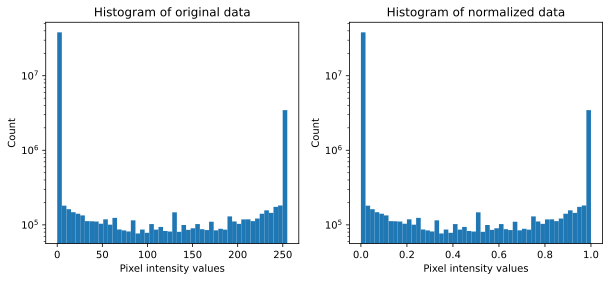

In [4]:
# Plot the data to see the data distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(train_data.flatten(), 50)
ax[0].set_xlabel("Pixel intensity values")
ax[0].set_ylabel("Count")
ax[0].set_title("Histogram of original data")
ax[0].set_yscale("log")

ax[1].hist(train_data_norm.flatten(), 50)
ax[1].set_xlabel("Pixel intensity values")
ax[1].set_ylabel("Count")
ax[1].set_title("Histogram of normalized data")
ax[1].set_yscale("log")

plt.show()

In [5]:
### Create train and test groups using dataloader
# Convert to tensor
train_data_tensor = torch.tensor(train_data_norm).float()
train_labels_tensor = torch.tensor(train_labels).long()
test_data_tensor = torch.tensor(test_data_norm).float()
test_labels_tensor = torch.tensor(test_labels).long()

# Test and dev set split
dev_dataset, test_dataset, dev_label, test_label = train_test_split(
    test_data_tensor, test_labels_tensor, test_size=0.5
)

# Convert into pytorch dataset
train_dataT = TensorDataset(train_data_tensor, train_labels_tensor)
dev_dataT = TensorDataset(dev_dataset, dev_label)
test_dataT = TensorDataset(test_dataset, test_label)

# Translate to dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_dataT,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
devset_loader = DataLoader(
    dev_dataT,
    batch_size=dev_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)
testset_loader = DataLoader(
    test_dataT,
    batch_size=test_dataT.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [6]:
# Create the model function
def createNewMNISTNet(nUnits, nLayers):
    # Model class
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Create dictonary to store the layers
            self.layers = nn.ModuleDict()
            # Input Layer
            self.layers['input'] = nn.Linear(784, nUnits)

            # Hidden Layers
            for layer in range(nLayers):
                self.layers[f'hidden{layer}'] = nn.Linear(nUnits, nUnits)

            # Output Layer
            self.layers['output'] = nn.Linear(nUnits, 10)


        # Forward Pass
        def forward(self, x):
            x = F.relu(self.layers['input'](x))
            
            for layer in range(nLayers):
                x = F.relu(self.layers[f'hidden{layer}'](x))
            
            return self.layers['output'](x)

    # Model Instance
    net = mnistNet()
    # Loss Function
    lossFun = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    return net, lossFun, optimizer

In [8]:
# Test the model
net, lossFun, optimizer = createNewMNISTNet()

X, y = next(iter(train_loader))
yHat = net(X)

loss = lossFun(yHat, y)

print(f"Loss: {loss}")
print(yHat)

Loss: 2.297919511795044
tensor([[-2.2529, -2.4217, -2.2903, -2.4868, -2.3574, -2.2072, -2.2264, -2.2245,
         -2.2931, -2.3020],
        [-2.2531, -2.4228, -2.2901, -2.4873, -2.3571, -2.2076, -2.2268, -2.2239,
         -2.2934, -2.3004],
        [-2.2536, -2.4206, -2.2885, -2.4884, -2.3573, -2.2071, -2.2288, -2.2249,
         -2.2937, -2.2993],
        [-2.2517, -2.4215, -2.2916, -2.4860, -2.3548, -2.2069, -2.2282, -2.2248,
         -2.2941, -2.3023],
        [-2.2536, -2.4233, -2.2881, -2.4871, -2.3588, -2.2075, -2.2274, -2.2240,
         -2.2914, -2.3014],
        [-2.2509, -2.4251, -2.2914, -2.4870, -2.3557, -2.2082, -2.2262, -2.2241,
         -2.2936, -2.3006],
        [-2.2527, -2.4220, -2.2897, -2.4889, -2.3558, -2.2057, -2.2279, -2.2237,
         -2.2951, -2.3014],
        [-2.2524, -2.4201, -2.2906, -2.4857, -2.3543, -2.2085, -2.2285, -2.2249,
         -2.2948, -2.3019],
        [-2.2518, -2.4225, -2.2902, -2.4876, -2.3550, -2.2074, -2.2274, -2.2249,
         -2.2940, -2.30

In [9]:
# Function to train the model
nEpochs = 30


def trainTheModel():
    net, lossFun, optimizer = createNewMNISTNet(lr=0.005)

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    devAcc = []

    # The Loop
    for epoch in range(nEpochs):
        # Train Mode
        net.train()
        # Loop over batches
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss
            batchLoss.append(loss.cpu().item())

            # Compute Batch Accuracy
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu()
            )

        # End of batch Loop
        # Average Loss
        losses[epoch] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # Dev Accuracy
        net.eval()
        X, y = next(iter(devset_loader))
        with torch.no_grad():
            yHat = net(X)

        devAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).cpu())
    # End of epoch

    return trainAcc, devAcc, losses, net

In [10]:
trainAcc, devAcc, losses, net = trainTheModel()

In [11]:
# Function to check the test Accuracy
def testModePerformance(dataset):
    testAcc = []
    # Model in evaluation mode
    net.eval()

    for X, y in dataset:
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(100 * (torch.argmax(yHat, axis=1) == y).float().cpu())

    return testAcc


testAcc = testModePerformance(testset_loader)

In [12]:
print(f"Train Accuracy is : {trainAcc[-1]}")
print(f"Dev Accuracy is : {devAcc[-1]}")
print(f"Test Accuracy is : {np.mean(testAcc)}")
print(len(testAcc), len(devAcc))
print(np.array(testAcc[0].detach()).shape)

Train Accuracy is : 97.76333618164062
Dev Accuracy is : 95.68000030517578
Test Accuracy is : 95.9800033569336
1 30
(5000,)


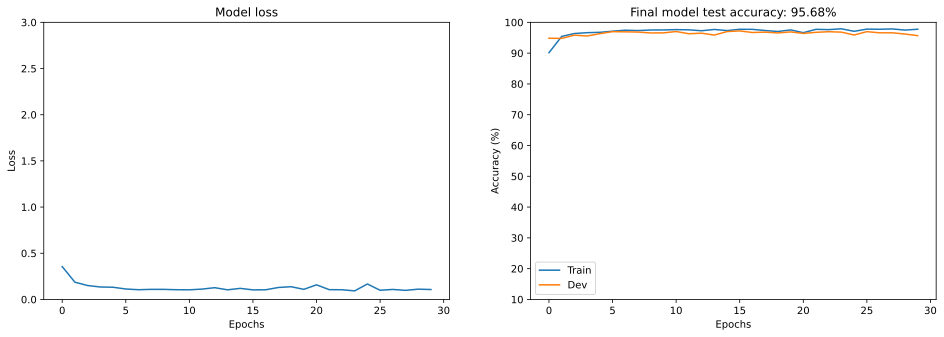

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses.cpu())
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(devAcc, label="Dev")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {devAcc[-1]:.2f}%")
ax[1].legend()

plt.show()

In [14]:
# run the model through for the test data
X, y = next(iter(testset_loader))
predictions = net(X).detach()

predictions

tensor([[ -84.3919,  -15.7000,  -22.0613,  ...,  -21.4008,  -29.2958,
          -14.5383],
        [-117.5401,  -34.7882,  -24.4702,  ...,  -60.7332,  -22.9617,
          -33.5150],
        [-426.9800,  -75.1735, -110.1291,  ..., -105.5349, -143.3447,
          -71.8149],
        ...,
        [-119.1360,  -27.0214,  -26.5616,  ...,    0.0000,  -90.6480,
          -38.6071],
        [-184.0522,  -33.0011,  -47.6806,  ...,  -45.8757,  -62.4731,
          -31.2003],
        [-151.4078,  -27.3340,  -39.2889,  ...,  -37.8588,  -51.6057,
          -25.7426]], device='cuda:0')

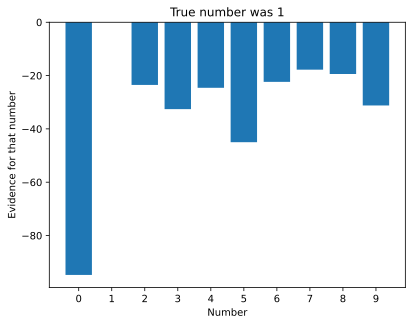

In [15]:
# Evidence for all numbers from one sample
sample2show = 122

plt.bar(range(10), predictions[sample2show].cpu())  # try adding exp!
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel("Evidence for that number")
plt.title("True number was %s" % y[sample2show].item())
plt.show()

[  26   28   60   79  103  142  145  175  187  245  248  267  278  353
  354  387  406  417  427  446  470  475  545  554  588  633  651  680
  685  699  720  740  789  806  809  859  880  942  950  971  977 1095
 1135 1141 1195 1202 1205 1265 1287 1313 1342 1409 1414 1433 1440 1467
 1500 1531 1537 1562 1629 1726 1734 1747 1755 1792 1795 1814 1858 1862
 1868 1879 1891 1948 1962 1989 2013 2016 2059 2061 2095 2102 2112 2116
 2118 2119 2124 2130 2181 2198 2233 2237 2240 2260 2283 2288 2359 2380
 2391 2411 2412 2423 2424 2487 2682 2694 2708 2725 2729 2738 2751 2789
 2843 2874 2897 2900 2933 3001 3020 3022 3045 3050 3076 3094 3100 3139
 3184 3203 3217 3226 3242 3258 3281 3293 3307 3354 3381 3413 3430 3452
 3483 3504 3517 3534 3556 3585 3589 3590 3603 3671 3712 3733 3806 3863
 3879 3944 3948 3955 3993 4011 4019 4085 4120 4140 4144 4211 4217 4219
 4220 4221 4241 4270 4279 4314 4329 4354 4359 4375 4390 4414 4436 4450
 4484 4540 4542 4561 4589 4596 4644 4662 4666 4726 4728 4745 4782 4784
 4822 

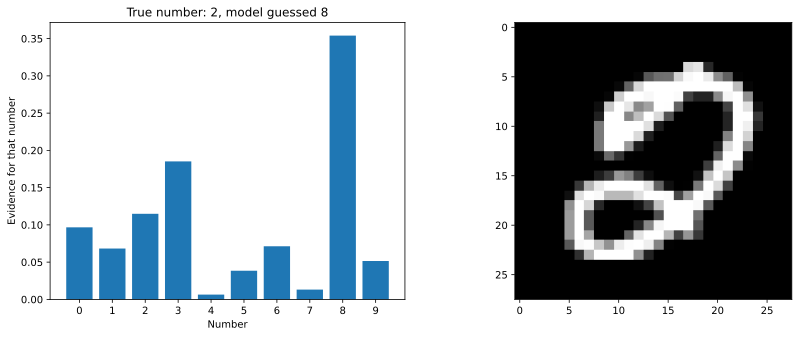

In [16]:
# find the errors
errors = np.where(torch.max(predictions, axis=1)[1].cpu() != y.cpu())[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 11

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]].cpu()))
ax[0].set_xticks(range(10))
ax[0].set_xlabel("Number")
ax[0].set_ylabel("Evidence for that number")
ax[0].set_title(
    "True number: %s, model guessed %s"
    % (
        y[errors[sample2show]].cpu().item(),
        torch.argmax(predictions[errors[sample2show]]).cpu().item(),
    )
)

ax[1].imshow(np.reshape(X[errors[sample2show], :].cpu(), (28, 28)), cmap="gray")

plt.show()

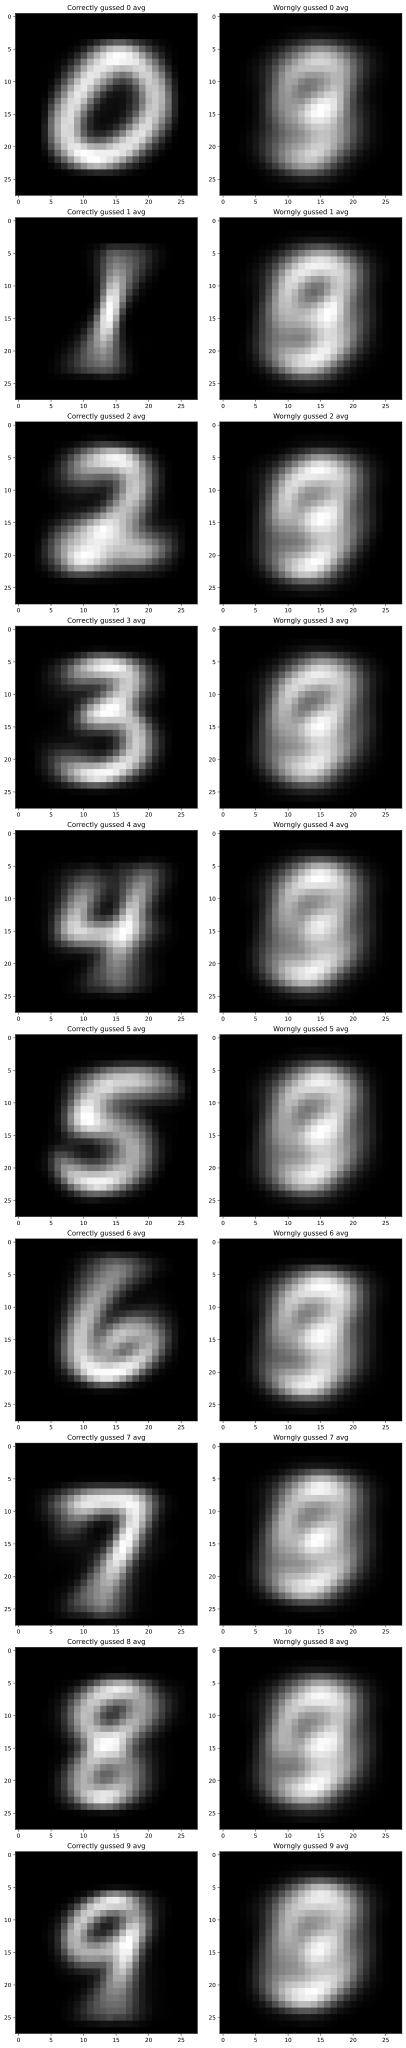

In [ ]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?

# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.

X, y = next(iter(testset_loader))
predictions = net(X).cpu().detach()

nums = np.arange(0, 10)
results = np.zeros((len(nums), 2))
fig, ax = plt.subplots(
    results.shape[0], results.shape[1], figsize=(10, 50), constrained_layout=True
)
# fig.tight_layout()
for i in nums:
    errors_Idx = np.where(torch.max(predictions, axis=1)[1].cpu() != i)
    corr_Idx = np.where(torch.max(predictions, axis=1)[1].cpu() == i)

    ax[i][0].imshow(torch.mean(X[corr_Idx], axis=0).reshape(28, 28).cpu(), cmap="gray")
    ax[i][0].set_title(f"Correctly gussed {i} avg")
    ax[i][1].imshow(
        torch.mean(X[errors_Idx], axis=0).reshape(28, 28).cpu(), cmap="gray"
    )
    ax[i][1].set_title(f"Worngly gussed {i} avg")
plt.show()

In [ ]:
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
#
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
#